In [202]:
# Import the libraries
import yfinance as yf

import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [139]:
# Download data using yfinance
df = yf.download('AAPL', start='2019-01-01', end='2024-1-01')


[*********************100%***********************]  1 of 1 completed


In [140]:
# get the number of rows and columns in the data set
df.shape

(1258, 6)

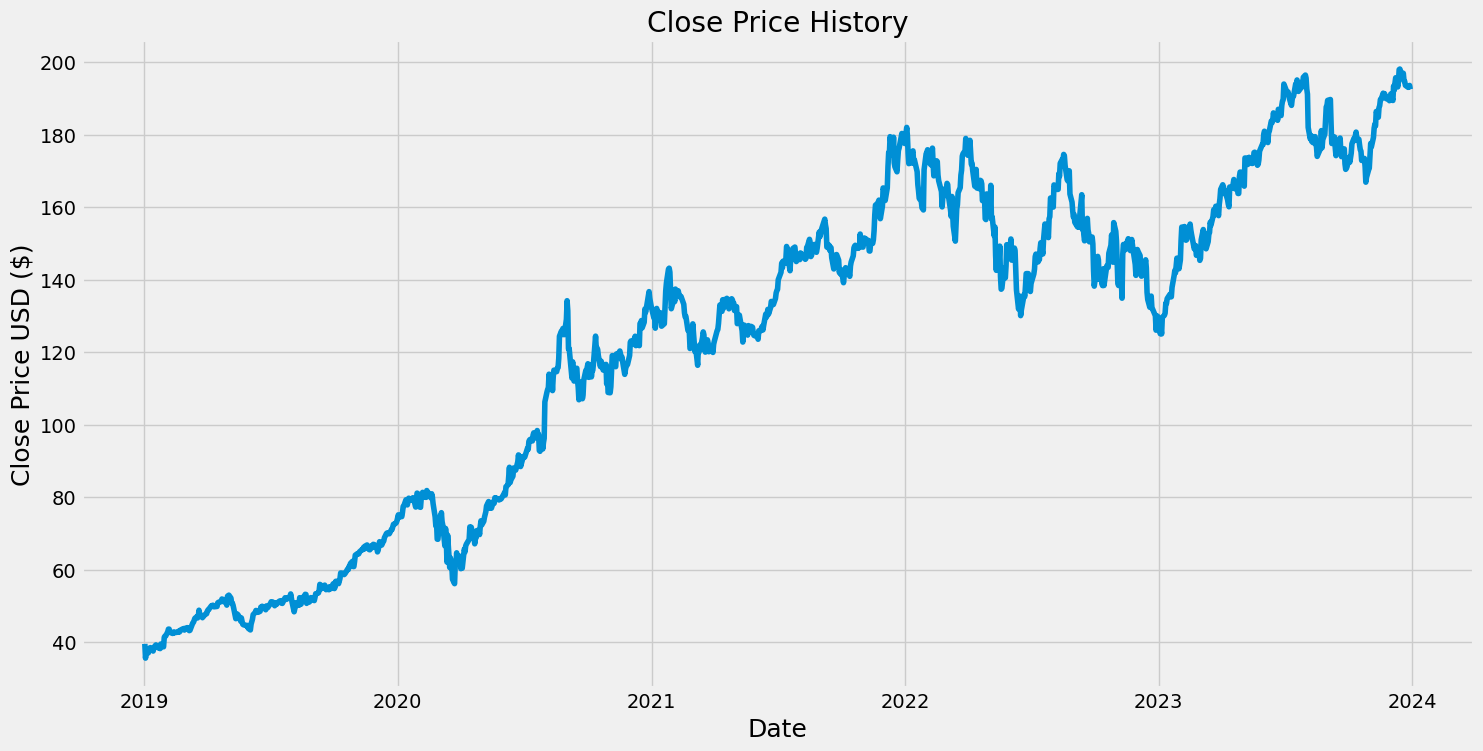

In [141]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [142]:
# Create a new dataframe with only the 'Close' column
data_close = df['Close']

# Convert the dataframe to a numpy array
dataset = data_close.values

# Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)


In [143]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))

# Create the scaled data
scaled_data = scaler.fit_transform(dataset)

scaled_data


array([[0.02419069],
       [0.        ],
       [0.00933486],
       ...,
       [0.96948862],
       [0.9721338 ],
       [0.96567473]])

In [144]:
# Create the training data set

# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :] # less than real data

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

    if i <= 60:
        print(x_train)
        print(y_train)
        print()

[array([0.02419069, 0.        , 0.00933486, 0.00882736, 0.01316416,
       0.01710111, 0.01785467, 0.01553247, 0.01201076, 0.01673203,
       0.01960784, 0.02102268, 0.02249905, 0.01708574, 0.01803921,
       0.01616301, 0.02394462, 0.02169935, 0.01920798, 0.03546328,
       0.03729335, 0.03741638, 0.0446905 , 0.04919645, 0.04928874,
       0.04421376, 0.04339869, 0.04189157, 0.04413687, 0.04304497,
       0.04399846, 0.04341406, 0.04419837, 0.04589004, 0.0443983 ,
       0.04733564, 0.04927335, 0.04942714, 0.05025758, 0.04761244,
       0.05041138, 0.05176471, 0.05127258, 0.04971934, 0.04661284,
       0.04724337, 0.0564552 , 0.05954633, 0.06077663, 0.06388311,
       0.06755862, 0.07048059, 0.06818915, 0.07069589, 0.08135332,
       0.07514033, 0.07158786, 0.06858899, 0.07117262, 0.07155709])]
[0.0734486651393094]



In [145]:
# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the data
x_train.shape

# The LSTM network expects the input to be three-dimensional in the form of the number of samples, the number of time steps, and the number of features.
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


(947, 60, 1)

In [146]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

c:\Users\billt\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [147]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [148]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

947/947 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0059


In [149]:
# Create the testing data set

# Create a new array containing scaled values from index training_data_len - 60 to e d
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :] # real data

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [150]:
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [151]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # unscaling the values

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [152]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

0.716135336583354

C:\Users\billt\AppData\Local\Temp\ipykernel_46852\4174446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


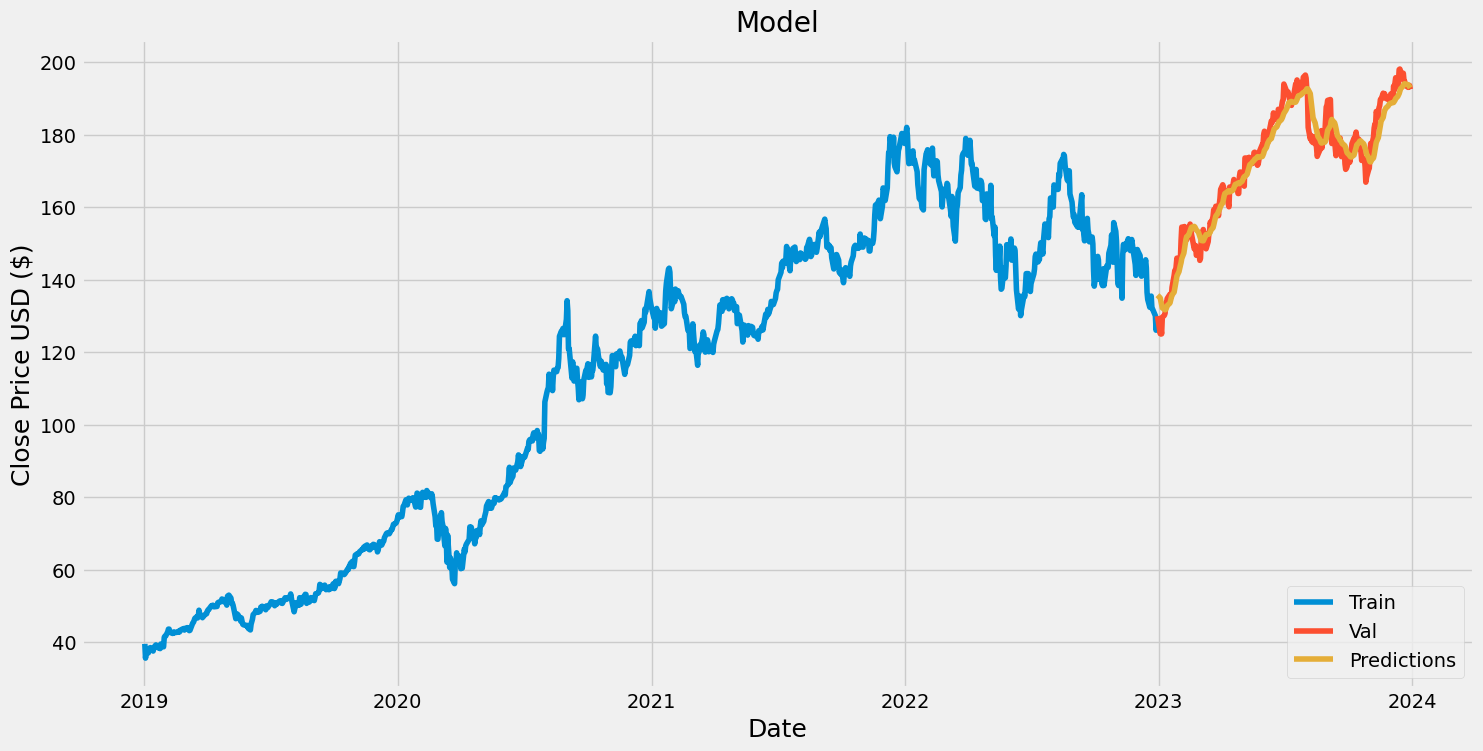

[*********************100%***********************]  1 of 1 completed


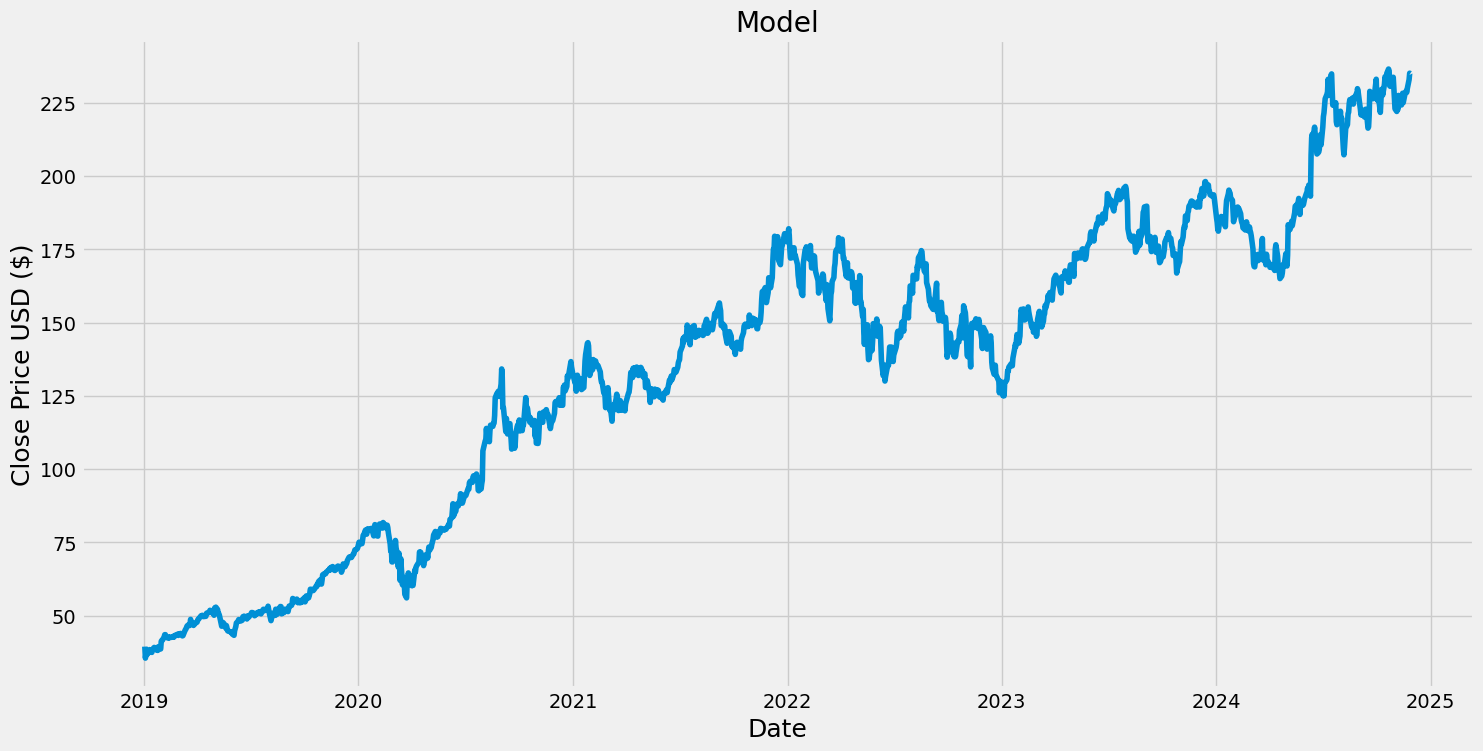

In [188]:
train = data_close[:training_data_len]
valid = data_close[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train["AAPL"])
plt.plot(valid[['AAPL', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

alldata = yf.download('AAPL', start='2019-01-01', end='2024-11-29')
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(alldata['Close'])
plt.show()
